In [26]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Will allow us to embed images in the notebook
%matplotlib inline


# @hidden_cell
# This function accesses a file in your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def get_object_storage_file_with_credentials_43eb42eeb0ed47e6bcd113acc56fb153(container, filename):
    """This functions returns a StringIO object containing
    the file content from Bluemix Object Storage."""

    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_ae7c73721c6aaba333eeb7edfad084f66dc4b2af','domain': {'id': '24fed1351c674eb3a6fbe574f3abf419'},
            'password': 'X8akJ{(R8]{mzpUu'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO(resp2.text)

df = pd.read_csv(get_object_storage_file_with_credentials_43eb42eeb0ed47e6bcd113acc56fb153('LoanPrediction', 'train_u6lujuX_CVtuZ9i.csv'))
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [27]:
#Check distribution of numeric variables.
df.describe()

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,NaN,NaN,NaN
50%,3812.500000,1188.500000,NaN,NaN,NaN
75%,5795.000000,2297.250000,NaN,NaN,NaN
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [28]:
#Look for missing values
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

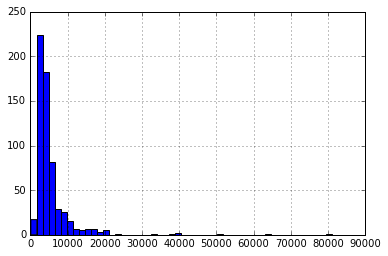

In [29]:
#We can also visualize data.
df['ApplicantIncome'].hist(bins=50)

OrderedDict([('ApplicantIncome',
              <matplotlib.axes._subplots.AxesSubplot at 0x7fa5bd89d0f0>)])

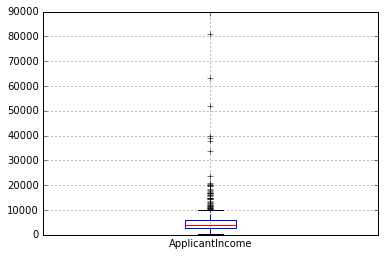

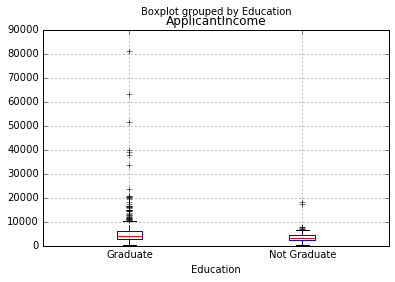

In [30]:
df.boxplot(column='ApplicantIncome', return_type='axes')
df.boxplot(column='ApplicantIncome', by='Education', return_type='axes')

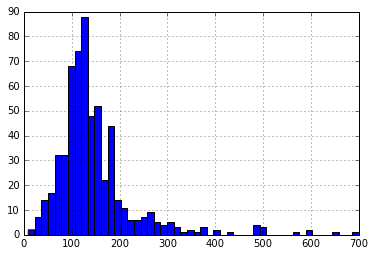

In [31]:
df['LoanAmount'].hist(bins=50)

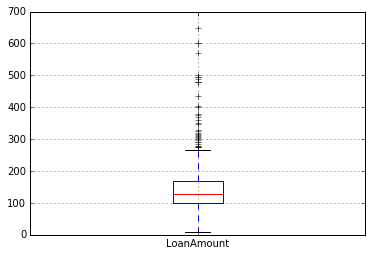

In [32]:
df.boxplot(column='LoanAmount', return_type='axes')

In [33]:
#STEP 2: Data Preperation

#Looking at the tables and charts above we have several data problem that we need to resolve.
# - 7 of 13 variables contain missing values.
# - Several of the numeric variable, like loan amount and annual income either:
#    - Outliers
#    - Feature Scaling

#There is no universal 'right choice' in how to correct missing data.
# - Dropping rows and/or columns that contain missing data may end up removing too many records, potentially making reliable analysis impossible.
# - Imputation of a missing values using means or a sensible placeholder value may produce better results.
# - Often the data point in question plays may place a large role in you approach.
# - There are some automated options to imput missing values. For example, sklearn.preprocessing import Inputer

#Take for example Credit history, we could build a model that is 74.9% accurate with just this field.
table = df.pivot_table(values='Loan_ID', index='Credit_History', columns='Loan_Status', aggfunc='count')
table.head()

Loan_Status,N,Y
Credit_History,,
0.0,82,7
1.0,97,378


In [34]:
#Self_Employed: 32 missing values. 85% of valid values are 'No', filling missing values with the most common value.

# Need to be mindful when you replace values in a dataset. Python code does not execute from top to bottom on each run. Once
# the value has been replaced it's replaced in memory.

#df['Self_Employed'].value_counts().plot(kind='bar')
df['Self_Employed'].fillna('No', inplace=True)
#df['Self_Employed'].value_counts().plot(kind='bar')

In [35]:
#Loan_Amount: 22 missing values.

table = df.pivot_table(values='LoanAmount', index='Self_Employed', columns='Education', aggfunc=np.median)
table.head()

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


In [36]:
# Median value of loan amount varies by 'Education' and 'Self_Employed'. Going to fill missing records with median based on this criteria.
# Interestg in recording this to work with more than two variables.
# NOTE: This will fail to run until 'Self_Employed' variable has been cleaned.
# NOTE: It will also fail to run after the variable has been cleaned. I.e., no records have any missing values to fill.
# NOTE: The main challenge here is that it's difficult to just 'try another solution'. You need to go back and rerun.

table = df.pivot_table(values='LoanAmount', index='Self_Employed', columns='Education', aggfunc=np.median)
table.head()

#Define function to return value of this pivot table
def fage(x):
    return table.loc[x['Self_Employed'], x['Education']]

#Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

table = df.pivot_table(values='LoanAmount', index='Self_Employed', columns='Education', aggfunc=np.median)
table.head()

Education,Graduate,Not Graduate
Self_Employed,,
No,130.0,113.0
Yes,157.5,130.0


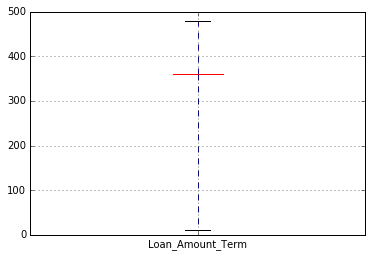

In [37]:
#Loan_Amount_Term: 14 missing values.

df.boxplot(column='Loan_Amount_Term', return_type='axes')

In [38]:
# Going to manually fill the values with the median.
#Loan_Amount_Term: Filling with median value.
df['Loan_Amount_Term'].fillna(360, inplace=True)

In [39]:
#Credit_History: 50 missing values.
#NOTE: Model produced a higher accuracy when missing value records were removed vs. filled.

#df['Credit_History'].fillna(0, inplace=True)
df.dropna(subset=['Credit_History'], inplace=True)

In [40]:
#Three demographic fields are left that contain missing values. No obvious solution exists. Going to drop rows in terms of speed.

# NOTE: We should attempt to model Gender using: ApplicantIncome, Property_Area, CoapplicantIncome, LoanAmount,, Loan_Amount_Term and Education. (SPSS C5 Suggestion.)

#df['Gender'].value_counts().plot(kind='bar')
#df['Married'].value_counts().plot(kind='bar')
#df['Dependents'].value_counts().plot(kind='bar')

df.dropna(subset=['Gender'], inplace=True)
df.dropna(subset=['Married'], inplace=True)
df.dropna(subset=['Dependents'], inplace=True)

In [41]:
#Review that are missing value issues have been resolved.
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [42]:
#We may want to create calculated values based on the existing data.

df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['LoanToIncomeRatio'] = df['LoanAmount'] / df['TotalIncome']
df.head(8)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,LoanToIncomeRatio
0,LP001002,Male,No,0,Graduate,No,5849,0.0,130.0,360.0,1.0,Urban,Y,5849.0,0.022226
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,6091.0,0.021015
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,3000.0,0.022000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,4941.0,0.024287
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,6000.0,0.023500
5,LP001011,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y,9613.0,0.027775
6,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y,3849.0,0.024682
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N,5540.0,0.028520


In [43]:
#Handling categorical data.

#Dependents: Map Ordinal Features
size_mapping = { '3+': 3, '2': 2, '1': 1, '0': 0 }
df['Dependents'] = df['Dependents'].map(size_mapping)

#Encoding Class Labels
from sklearn.preprocessing import LabelEncoder
var_mod = ['Gender', 'Married', 'Education','Self_Employed', 'Loan_Status']

class_le = LabelEncoder()
for i in var_mod:
    df[i] = class_le.fit_transform(df[i])

#Dummy Features for categorical variables with three or more features. (OneHotEncoder)
df_temp = pd.get_dummies(df[['Property_Area']])
df = pd.concat([df, df_temp], axis=1)
del df['Property_Area']

#Last but no least
del df['Loan_ID']


#Confirm data types are set correctly.
df.dtypes

Gender                       int64
Married                      int64
Dependents                   int64
Education                    int64
Self_Employed                int64
ApplicantIncome              int64
CoapplicantIncome          float64
LoanAmount                 float64
Loan_Amount_Term           float64
Credit_History             float64
Loan_Status                  int64
TotalIncome                float64
LoanToIncomeRatio          float64
Property_Area_Rural        float64
Property_Area_Semiurban    float64
Property_Area_Urban        float64
dtype: object

In [44]:
#Partition data into training and testing set.

target = "Loan_Status"
predictors = ["Gender", "Married", "Dependents", "Education", "Self_Employed", "ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History", "TotalIncome", "LoanToIncomeRatio", "Property_Area_Rural", "Property_Area_Semiurban", "Property_Area_Urban"]
#(Random Forest)
#predictors = ["Credit_History", "LoanToIncomeRatio", "TotalIncome", "ApplicantIncome", "LoanAmount"]
#(SBS)predictors = ['Self_Employed', 'ApplicantIncome', 'Credit_History', 'TotalIncome']

from sklearn.cross_validation import train_test_split
X, y = df[predictors].values, df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [45]:
#Bring features onto a common scale. (Normalization vs. Standardization)
#Majority of machine learning and optimization algorthims behave better if features are on a common scale.
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.fit_transform(X_test)

In [46]:
#Feature Selection
# To avoid overfitting the model we may want to reduce the dimensionality of the data.
# Many different techniques exist to assess which features to include or exclude.

#Feature importance with random trees.
print ("Tree Build Started...")
from sklearn.ensemble import RandomForestClassifier
feat_labels = df[predictors].columns
forest = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print ("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]])) 
print ("Tree Completed.")

Tree Build Started...
 1) Credit_History                 0.253955
 2) LoanToIncomeRatio              0.135563
 3) TotalIncome                    0.122397
 4) ApplicantIncome                0.118579
 5) LoanAmount                     0.111205
 6) CoapplicantIncome              0.073446
 7) Loan_Amount_Term               0.038045
 8) Dependents                     0.033499
 9) Married                        0.020296
10) Property_Area_Semiurban        0.018077
11) Education                      0.017678
12) Property_Area_Rural            0.016614
13) Gender                         0.015178
14) Self_Employed                  0.013426
15) Property_Area_Urban            0.012044
Tree Completed.


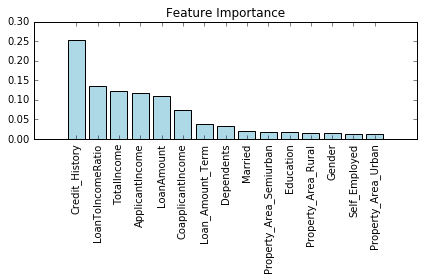

In [47]:
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.tight_layout()
plt.show()

In [48]:
#We could also implement Sequential Backward Selection (SBS) as a method to reduce the feature subspace.


from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score, test_size=0.15, random_state=0):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim-1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_scores_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[: self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
sbs = SBS(knn, k_features=1)

#Something is wrong, target is in the predictor set.
sbs.fit(X_train_std, y_train)

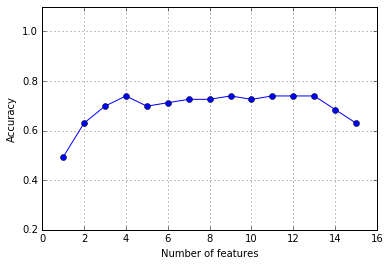

In [49]:
k_feat = [len(k) for k in sbs.subsets_]
plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.2, 1.1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.show()

In [50]:
features = list(sbs.subsets_[11])
print(df[predictors].columns[:][features])

Index(['Self_Employed', 'ApplicantIncome', 'Credit_History', 'TotalIncome'], dtype='object')


In [51]:
# instantiate a logistic regression model, and fit with X and y
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model = model.fit(X_train, y_train)

# check the accuracy on the training set
scores = model.score(X_train, y_train)
print ("Accuracy: %.2f" % (scores))

Accuracy: 0.82


In [52]:
#Split training data into folds and compute accuracy for each fold. Looking for stability across the folds.

from sklearn.cross_validation import cross_val_score
scores = cross_val_score(LogisticRegression(), X_train, y_train, scoring='accuracy', cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2.0))

Accuracy: 0.82 (+/- 0.03)


In [53]:
#Score the holdout 'test' records.

scores = model.score(X_test, y_test)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2.0))

Accuracy: 0.78 (+/- 0.00)


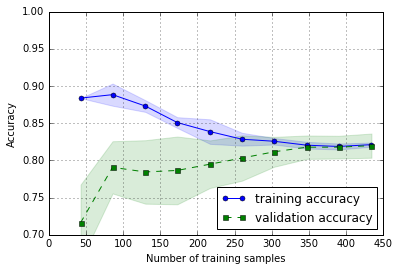

In [54]:
from sklearn.learning_curve import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = model,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes = np.linspace(0.1, 1.0, 10),
                                                       cv = 10,
                                                        n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
plt.fill_between(train_sizes,
               train_mean + train_std,
               train_mean - train_std,
               alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.70, 1.0])

plt.show()

[[ 4 11]
 [ 1 38]]


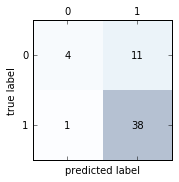

In [55]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()
